    This Source Code Form is subject to the terms of the Mozilla Public
    License, v. 2.0. If a copy of the MPL was not distributed with this
    file, You can obtain one at http://mozilla.org/MPL/2.0/.

# Load and preprocess dataset

Load the dataset skipping some columns. This time use the category datatype for the classification column.

In [1]:
import pandas as pd
from sklearn.preprocessing import StandardScaler

In [80]:
csv_file = 'datasets/netflow-v1/NF-ToN-IoT.csv'
ignore_cols = {'IPV4_SRC_ADDR', 'IPV4_DST_ADDR', 'Label'}

In [81]:
df = pd.read_csv(csv_file,
                 usecols=lambda x: x not in ignore_cols,
                 dtype={'Attack': 'category'})
df.head()

,L4_SRC_PORT,L4_DST_PORT,PROTOCOL,L7_PROTO,IN_BYTES,OUT_BYTES,IN_PKTS,OUT_PKTS,TCP_FLAGS,FLOW_DURATION_MILLISECONDS,Attack
0,63318,443,6,91.00,181,165,2,1,24,327,Benign
1,57442,15600,17,0.00,63,0,1,0,0,0,Benign
2,57452,15600,17,0.00,63,0,1,0,0,0,Benign
3,138,138,17,10.16,472,0,2,0,0,0,Benign
4,51989,15600,17,0.00,63,0,1,0,0,0,Benign


The decision tree and random forest classifiers work best with unnormalised data but the VAE requires inputs to conform to a standard normal distribution.
This is done using the `transform` and `inverse_transform` methods from the `StandardScaler` class. Before use, the scaler must be 'fit' to the data to caluclate the mean and standard deviation for each feature.

In [82]:
scaler = StandardScaler().fit(df.iloc[:,:-1])

# Train classifier model

In [83]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from xgboost import XGBClassifier, XGBRFClassifier

In [84]:
X, y = df.iloc[:,:-1], df.iloc[:,-1].cat.codes
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42)

In [86]:
classifier = XGBRFClassifier(n_estimators=17, random_state=42)
classifier.fit(X_train, y_train);

In [87]:
y_pred = classifier.predict(X_test)
print(classification_report(y_test, y_pred, target_names=df.Attack.cat.categories))

C:\Users\lh\dev\causal-ids\.env\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


              precision    recall  f1-score   support

      Benign       0.99      0.99      0.99     67595
        ddos       0.73      0.83      0.78     81953
         dos       0.31      0.01      0.01      4468
   injection       0.60      0.93      0.73    116783
        mitm       0.74      0.18      0.29       334
    password       0.33      0.00      0.00     38850
    scanning       0.00      0.00      0.00      5384
         xss       0.00      0.00      0.00     25136
    backdoor       1.00      0.99      0.99      4289
  ransomware       0.74      0.93      0.82        27

    accuracy                           0.72    344819
   macro avg       0.54      0.48      0.46    344819
weighted avg       0.63      0.72      0.64    344819



C:\Users\lh\dev\causal-ids\.env\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\lh\dev\causal-ids\.env\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


# Train explanation model

The VAE implementation is copied from the paper though the model was altered slightly to suit our dataset.

In [88]:
import numpy as np
import torch
import torch.nn as nn

from tqdm import tqdm

The encoder takes a batch of rows (32 by default) from the training dataset. This is fed forward into a hidden layer first and then into two fully connected layers with outputs of size `z_dim`, which is the size of the latent vector. This is then used to parameterise a normal distribution, which is sampled from to produce the output latents.

In [89]:
class Encoder(nn.Module):
    def __init__(self, x_dim, z_dim, hidden_dim=100):
        super().__init__()

        self.model = nn.Sequential(
            nn.Linear(int(x_dim),hidden_dim),
            nn.Sigmoid()
        )
        
        self.f_mu = nn.Linear(hidden_dim, z_dim)
        self.f_var = nn.Linear(hidden_dim, z_dim)

    def encode(self, X):
        h1 = self.model(X)
        return self.f_mu(h1),self.f_var(h1)
    
    def reparameterize(self, mu, logvar):
        std = torch.exp(0.5*logvar)
        eps = torch.randn_like(std)
        return mu + eps*std
    
    def forward(self, X):
        mu, logvar = self.encode(X)
        z = self.reparameterize(mu, logvar)
        return z, mu, logvar

In [90]:
class Decoder(nn.Module):
    def __init__(self, x_dim, z_dim, hidden_dim=100):
        super().__init__()

        self.model = nn.Sequential(
            nn.Linear(z_dim,hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim,x_dim)
        )

    def forward(self, z):
        X = self.model(z)
        return X  

In [91]:
K = 2
L = 8

In [92]:
X_train_norm = scaler.transform(X_train)
train_loader = torch.utils.data.DataLoader(X_train_norm, batch_size=32)
encoder = Encoder(X_train.shape[1], K+L)
decoder = Decoder(X_train.shape[1], K+L)
decoder.cuda()
encoder.cuda();

In [93]:
params = list(decoder.parameters()) + list(encoder.parameters())
optimizer = torch.optim.Adam(params, lr=0.0001)

In [94]:
def calc_loss(X, Xhat, z_loc, z_scale):
    batch_size = X.shape[0]
    sse_loss = torch.nn.MSELoss(reduction = 'sum')
    KLD = 1./batch_size + -0.5*torch.sum(1 + z_scale - z_loc.pow(2) - z_scale.exp())
    Xhat = torch.Tensor(Xhat).cuda()
    mse = 1./batch_size * sse_loss(Xhat, X)
    return mse + KLD

In [95]:
def reconstruct(Xnorm):
    z, _, _ = encoder(torch.tensor(Xnorm).cuda().float())
    Xhat = scaler.inverse_transform(decoder(z).cpu().detach())
    return pd.DataFrame(Xhat, columns=X.columns)

This is the function from the paper to calculate the "causal effect" or mutual information between the causal latents and classifier result.

In [96]:
eps = 1e-8

def C(a: int, b: int, cats: int, *, independent=False, conditional=False):
    I = 0.
    qs = np.zeros(cats)
    for _ in range(a):
        alphas = np.random.randn(a)
        latents = np.empty((b,K+L))

        for j in range(b):
            betas = np.random.randn(b)
            latents[j] = np.concatenate((alphas, betas))

        Xhat = reconstruct(latents)
        yhat = classifier.predict_proba(Xhat)
        
        ps = np.sum(yhat, axis=0)
        ps = ps / b / ps.max() # p(y | alpha)
        ps_entropy = np.sum(ps * np.log(ps + eps))
        I += ps_entropy / a
        qs += ps / a # q(y)
    qs_entropy = np.sum(qs * np.log(qs+eps))
    I -= qs_entropy
    return I

In [97]:
def train(use_cuda=False):
    epoch_loss = 0.
    
    for X in tqdm(train_loader):
        if use_cuda:
            X = X.cuda()
        X = X.float()
        optimizer.zero_grad()
        z, z_loc, z_scale = encoder(X)
        Xhat = scaler.inverse_transform(decoder(z).cpu().detach())
        loss = -C(K, L, df['Attack'].cat.categories.size) + 0.05 * calc_loss(X, Xhat, z_loc, z_scale)
        loss.backward()
        optimizer.step()
        epoch_loss += loss
    return epoch_loss / train_loader.dataset.shape[0]

In [98]:
train(True)

100%|████████████████████████████████████████████████████████████████████████████| 32327/32327 [23:31<00:00, 22.90it/s]


tensor(13317648., device='cuda:0', grad_fn=<DivBackward0>)

In [99]:
X_test_norm = scaler.transform(X_test)
X_test_hat = reconstruct(X_test_norm)

In [100]:
X_test_hat

,L4_SRC_PORT,L4_DST_PORT,PROTOCOL,L7_PROTO,IN_BYTES,OUT_BYTES,IN_PKTS,OUT_PKTS,TCP_FLAGS,FLOW_DURATION_MILLISECONDS
0,44123.085046,5886.054909,6.225259,30.008155,35263.318379,-12524.637230,-118.959081,472.280284,22.766611,55647.538622
1,45012.632554,8519.634431,7.226421,36.421558,31408.160147,10564.717236,-592.841222,637.481299,25.144782,62517.974033
2,50740.545374,-926.458363,7.814044,14.485936,8654.845786,8130.548107,-1203.464033,509.786975,22.292382,-34766.341460
3,44222.591964,8331.264775,6.532880,25.807683,35583.105807,15891.786356,-1248.520521,625.447066,22.920582,50520.890822
4,43996.833114,6958.628121,7.516494,6.624276,35153.001131,-1478.887139,-740.294571,80.952522,20.020696,12184.901365
...,...,...,...,...,...,...,...,...,...,...
344814,41115.684318,7448.334759,6.494275,21.385445,37774.510214,-9996.742674,-24.667453,-14.377236,21.652719,11399.990425
344815,45439.129688,222.933623,6.584344,21.540037,45213.488678,-21324.438405,42.136554,370.056424,21.632667,39776.648483
344816,37700.601143,2608.265424,6.010467,35.291555,20287.446938,8054.867268,-736.782432,568.457140,23.375727,75833.394078
344817,41000.345132,14850.776248,6.562725,31.651366,40999.152335,-14736.678204,-484.438599,301.076348,19.288318,110140.532180


In [101]:
y_pred = classifier.predict(X_test_hat)
print(classification_report(y_test, y_pred, target_names=df.Attack.cat.categories))

C:\Users\lh\dev\causal-ids\.env\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\lh\dev\causal-ids\.env\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


              precision    recall  f1-score   support

      Benign       0.19      0.31      0.24     67595
        ddos       0.24      0.19      0.21     81953
         dos       0.00      0.00      0.00      4468
   injection       0.35      0.00      0.00    116783
        mitm       0.00      0.00      0.00       334
    password       0.00      0.00      0.00     38850
    scanning       0.00      0.00      0.00      5384
         xss       0.00      0.00      0.00     25136
    backdoor       0.01      0.50      0.02      4289
  ransomware       0.00      0.00      0.00        27

    accuracy                           0.11    344819
   macro avg       0.08      0.10      0.05    344819
weighted avg       0.22      0.11      0.10    344819



C:\Users\lh\dev\causal-ids\.env\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


# Visualisation

In [102]:
z_sweep = range(-30, 30, 5)
sweep_X = X_test_norm[0]

In [103]:
enc_z, _, _ = encoder(torch.tensor(sweep_X).cuda().float())

In [104]:
zz = []
for nudge in z_sweep:
    ar = enc_z.clone()
    ar[0:K] += nudge
    dec_X = scaler.inverse_transform(decoder(ar).cpu().detach().reshape(1, -1))
    zz.append((
        ar,
        dec_X,
        classifier.predict(dec_X)
    ))

In [105]:
print("Sweeping from -30 to +30 in steps of 5")
cats = df['Attack'].cat.categories
for enc, dec, res in zz:
    causal = [int(x) for x in enc.tolist()[:K]]
    print(f"Causal vars: {causal}, result: {cats[res][0]}")

Sweeping from -30 to +30 in steps of 5
Causal vars: [-30, -29], result: Benign
Causal vars: [-25, -24], result: Benign
Causal vars: [-20, -19], result: Benign
Causal vars: [-15, -14], result: Benign
Causal vars: [-10, -9], result: backdoor
Causal vars: [-5, -4], result: backdoor
Causal vars: [0, 0], result: backdoor
Causal vars: [4, 5], result: ddos
Causal vars: [9, 10], result: ddos
Causal vars: [14, 15], result: ddos
Causal vars: [19, 20], result: backdoor
Causal vars: [24, 25], result: backdoor


In [106]:
before = sweep_X
after = scaler.transform(zz[7][1])
feature_names = df.columns[:-1]

C:\Users\lh\dev\causal-ids\.env\Lib\site-packages\sklearn\base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


In [107]:
import matplotlib.pyplot as plt

In [108]:
viz_df = pd.DataFrame(zip(feature_names, before, after.reshape(10), classifier.feature_importances_), columns=['Features', 'Before', 'After', 'Importance'])
viz_df.sort_values('Importance', inplace=True, ignore_index=True)
viz_df

,Features,Before,After,Importance
0,IN_BYTES,-0.005665,0.233181,0.012476
1,FLOW_DURATION_MILLISECONDS,-0.051212,1.067776,0.023274
2,L4_SRC_PORT,0.590043,0.089120,0.033855
3,IN_PKTS,-0.004508,-0.601386,0.034675
4,L7_PROTO,-0.613615,0.284245,0.039081
5,OUT_BYTES,-0.004906,-0.123435,0.050773
6,PROTOCOL,-0.301000,-0.651070,0.052976
7,OUT_PKTS,-0.003239,1.040892,0.149502
8,TCP_FLAGS,0.705718,1.109586,0.200292
9,L4_DST_PORT,-0.418907,0.086754,0.403096


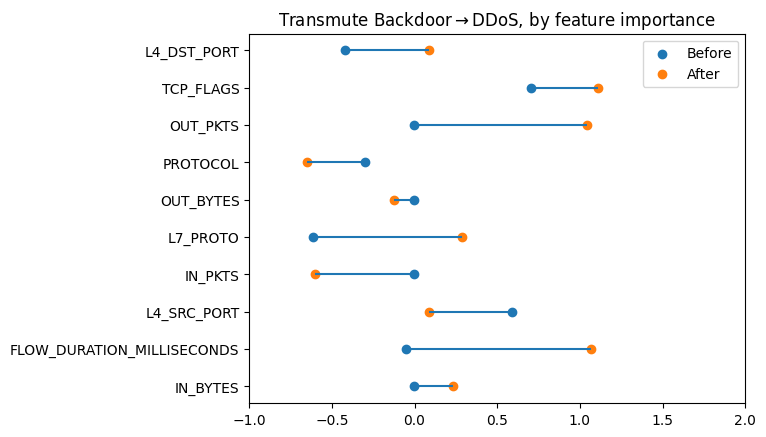

In [109]:
plt.scatter(viz_df.Before, viz_df.Features, label='Before')
plt.scatter(viz_df.After, viz_df.Features, label='After')
plt.hlines(y=viz_df.Features, xmin=viz_df.Before, xmax=viz_df.After)
plt.legend(loc='upper right')
plt.title('Transmute Backdoor$\\rightarrow$DDoS, by feature importance')
plt.xlim([-1,2])
plt.savefig('tranmuted_sample.png', bbox_inches = "tight");

In [33]:
zz = []
for nudge in z_sweep:
    ar = enc_z.clone()
    ar[-L:] += nudge
    dec_X = decoder(ar)
    zz.append((
        ar,
        dec_X,
        classifier.predict(dec_X.view([1,10]).cpu().detach(), validate_features=False)
    ))

In [34]:
print("Sweeping from -30 to +30 in steps of 5")
cats = df['Attack'].cat.categories
for enc, dec, res in zz:
    noncausal = [int(x) for x in enc.tolist()[-L:]]
    print(f"Non-causal vars: {noncausal}, result: {cats[res][0]}")

Sweeping from -30 to +30 in steps of 5
Non-causal vars: [-30, -30, -29, -28, -29, -30, -30, -30], result: Reconnaissance
Non-causal vars: [-25, -25, -24, -23, -24, -25, -25, -25], result: Reconnaissance
Non-causal vars: [-20, -20, -19, -18, -19, -20, -20, -20], result: Reconnaissance
Non-causal vars: [-15, -15, -14, -13, -14, -15, -15, -15], result: Reconnaissance
Non-causal vars: [-10, -10, -9, -8, -9, -10, -10, -10], result: Reconnaissance
Non-causal vars: [-5, -5, -4, -3, -4, -5, -5, -5], result: Reconnaissance
Non-causal vars: [0, 0, 0, 1, 0, 0, 0, 0], result: DDoS
Non-causal vars: [4, 4, 5, 6, 5, 4, 4, 4], result: DDoS
Non-causal vars: [9, 9, 10, 11, 10, 9, 9, 9], result: DDoS
Non-causal vars: [14, 14, 15, 16, 15, 14, 14, 14], result: DDoS
Non-causal vars: [19, 19, 20, 21, 20, 19, 19, 19], result: DDoS
Non-causal vars: [24, 24, 25, 26, 25, 24, 24, 24], result: DDoS


In [ ]:
print("Feature importance:")
for feature, importance in zip(X.columns, classifier.feature_importances_):
    print(f"{feature}: {importance:.2f}")

In [ ]:
sweep_X = X_test_norm
true_y = classifier.predict(sweep_X)
recon = sweep_X[true_y == 3]

In [ ]:
enc_z, _, _ = encoder(torch.tensor(recon).cuda().float())

In [ ]:
for nudge in range(15):
    new_z = enc_z.clone()
    enc_z[:,:K] += nudge
    decoded = decoder(new_z)
    y_pred = classifier.predict(scaler.inverse_transform(decoded.cpu().detach()))

In [ ]:
enc_z[:,:K] += 15.
y_pred = classifier.predict(scaler.inverse_transform(decoder(enc_z).cpu().detach()))

In [ ]:
print(classification_report(y_test[true_y == 3], y_pred, target_names=df.Attack.cat.categories))